Mount the drive

In [1]:
# Mount your drive to access the dataset.
from google.colab import drive
drive.mount('/content/gdrive')
!ls -l "/content/gdrive/My Drive/"

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/seefood': No such file or directory
total 1854
drwx------ 2 root root   4096 Feb 20  2021  3D
-rw------- 1 root root 708820 Dec  3  2020  7032780.pdf
-rw------- 1 root root   6439 Dec  2  2019 '7032780-sol (1).pdf'
-rw------- 1 root root   6649 Dec  3  2020  7032780-sol.pdf
-rw------- 1 root root  83532 Nov 10  2020 'Antonio Acunzo Report Lab 1.pdf'
-rw------- 1 root root 211489 Dec  7  2020 'Antonio Acunzo Report Lab 2.pdf'
drwx------ 2 root root   4096 Nov 17  2020 'Chiti - Architetture e tecnologie per reti esistenti'
drwx------ 2 root root   4096 Jun 23  2020 'Colab Notebooks'
-rw------- 1 root root    560 Feb 23  2021  default.cfg
drwx------ 2 root root   4096 Oct 12 12:45  IVA
drwx------ 2 root root   4096 Jun 18  2020 'Lezioni Marinai'
drwx------ 2 root root   4096 Jun 13  2020  Marabissi
-rw------- 1 root root 411188 Dec  2  2019  PdS-magistrale-ambiti-Acunzo-Antonio-7032780.pdf
drwx------ 2 root root   4096 Mar 24  2020 

Save some useful paths

In [2]:
coord_df_path = '/content/gdrive/My Drive/IVA/Datasets/info/2d_skeletal_data_unbc_coords.csv'
seq_df_path = '/content/gdrive/My Drive/IVA/Datasets/info/2d_skeletal_data_unbc_sequence.csv'
fig_dir = '/content/gdrive/My Drive/IVA/Datasets/info/histogram.png'
dataset_dir = '/content/gdrive/My Drive/IVA/Datasets/info/'

# 1) Information on dataset distribution

In [ ]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt

Prints the average, maximum and minimum length of the sequences and saves a histogram with all the lengths of the sequences

In [ ]:
data = pd.read_csv(seq_df_path)

print(data)

print("Info su lunghezza sequenze del dataset:")
print("Medium length : " , data["num_frames"].mean())
print("Max length : " ,data["num_frames"].max())
print("Min length : " ,data["num_frames"].min())

data['num_frames'].plot(kind='hist',bins=200)
plt.axvline(dati['num_frames'].mean(), c='red')
plt.xlabel('Number of Frame')
plt.ylabel('Grequencies')
plt.title("sequence length distribution")
plt.savefig(fig_dir, dpi=200)
plt.close()

plt.show()


# 2) Selection of Landmarks 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

Possible landmarks selection:

*   Eyes *→* group_1
*   Eyebrows *→* group_2
*   Nose *→* group_3
*   Mouth *→* group_4
*   Eyes + Eyebrows *→* group_5
*   Nose + Mouth *→* group_6
*   All *→* group_7




In [28]:
# Eye
group_1 = [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

# Eyebrows
group_2 = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# Nose
group_3 = [27, 28, 29, 30, 31, 32, 33, 34, 35]

# Mouth
group_4 = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

# Eyes + Eyebrows
group_5 = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

# Nose + Mouth
group_6 = [27, 28, 29, 30, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

# All
group_7 = range(0, 66)


Select the group of the landmarks to be used

In [ ]:
selected_lndks_idx = group_7

Plot the landmarks selected of frame 0 of sequence named "['bn080t1aeunaff']"

Sequence: ['bn080t1aeunaff'] --> VAS: 6 - Frame numbers: 203


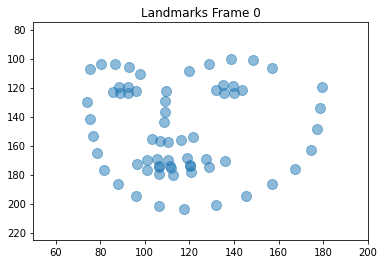

In [41]:
seq_name = "['bn080t1aeunaff']"

coord_df = pd.read_csv(coord_df_path)
seq_df = pd.read_csv(seq_df_path)

seq = seq_df.query('sequence_name== @seq_name')
seq_idx = seq.index.values[0]

VAS = seq['VAS'][seq_idx]
num_frames = seq['num_frames'][seq_idx]

print("Sequence: " + seq_name + " --> VAS: " + str(VAS) + " - Frame numbers: " + str(num_frames))
lndks = coord_df.loc[coord_df['0'] == seq_idx].values

num_lndks = 66
lndks = lndks[:, 2:]

lndks_x = lndks[:, :num_lndks]
lndks_y = lndks[:, num_lndks:]

selected_x = []
selected_y = []
lndks_selected_x = []
lndks_selected_y = []
for n in range(0,num_frames):
    for i in selected_lndks_idx:
        selected_x.append(lndks_x[n][i])
        selected_y.append(lndks_y[n][i])
    lndks_selected_x.append(selected_x)
    lndks_selected_y.append(selected_y)
    selected_x = []
    selected_y = []

lndks_selected_x = np.array(lndks_selected_x)
lndks_selected_y = np.array(lndks_selected_y)


plt.title("Landmarks Frame " + str(0))
plt.scatter(lndks_selected_x[0, :], lndks_selected_y[0, :], s=100, alpha=0.5)
#plt.ylim(75,225)
plt.xlim(50,200)
plt.ylim(75,225)
plt.gca().invert_yaxis()

plt.show()

# 3) Dataset Generation


In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import operator
from sklearn.preprocessing import RobustScaler

##2.1) Utility functions
Define some utilities functions

In [ ]:
# Get the velocities of all selected landmark for each frame of each sequence

def get_velocities_frames():
  
  coord_df = pd.read_csv(coord_df_path)
  seq_df = pd.read_csv(seq_df_path)
  velocities = []
  for seq_num in np.arange(seq_df.shape[0]):
      lndks = coord_df.loc[coord_df['0'] == seq_num].values
      lndks = lndks[:, 2:]
      num_lndks = 66
      num_frames = seq_df['num_frames'][seq_num]
      centroid_x = np.array([np.sum(lndks[i, 0:num_lndks]) / num_lndks for i in range(num_frames)])
      centroid_y = np.array([np.sum(lndks[i, num_lndks:]) / num_lndks for i in range(num_frames)])

      offset = np.hstack((np.repeat(centroid_x.reshape(-1, 1), num_lndks, axis=1),
                          np.repeat(centroid_y.reshape(-1, 1), num_lndks, axis=1)))

      lndks_centered = lndks - offset
      lndks_centered[:, 30] = centroid_x

      lndks_centered[:, 30 + num_lndks] = centroid_y
      lndk_vel = np.power(np.power(lndks_centered[0:lndks_centered.shape[0] - 1, 0:num_lndks] -
                                  lndks_centered[1:lndks_centered.shape[0], 0:num_lndks], 2) +
                          np.power(lndks_centered[0:lndks_centered.shape[0] - 1, num_lndks:] -
                                  lndks_centered[1:lndks_centered.shape[0], num_lndks:], 2), 0.5)
      data_velocities = []
      for k in np.arange(1, lndk_vel.shape[0]):
          data_velocities.append(np.array(lndk_vel[k, selected_lndks_idx]))
      velocities.append(np.array(data_velocities))
  return velocities

##2.2) Dataset Generation

In [ ]:
# Create two csv files, one for the training dataset and one for the test dataset

velocities = get_velocities_frames()
seq_df = pd.read_csv(seq_df_path)

list = []
element = []
sequenza = []
for id_seq in range(0, len(velocities)):
    vas = seq_df.iloc[id_seq][1]
    element.append(id_seq)
    sequenza = velocities[id_seq]
    for id_frames in range(0, len(sequenza)):
        element.append(id_frames)
        frame = sequenza[id_frames]
        for v in range(0, len(frame)):
            velocita = frame[v]
            element.append(velocita)
        element.append(vas)
        list.append(element)
        element = [id_seq]
    element = []

col = ['Sequenza','Frame']
for i in range(0, len(selected_lndks_idx)):
    s = 'Vel' + str(i)
    col.append(s)
col.append('Label')

df = pd.DataFrame(list,columns=col)

print(df)

train = df.loc[(df['Sequenza'] < 180)]
test = df.loc[(df['Sequenza'] >= 180)]

name_csv_train = dataset_dir + 'train-velocity-' + str(len(selected_lndks_idx)) + '.csv'
name_csv_test = dataset_dir + 'test-velocity-' + str(len(selected_lndks_idx)) + '.csv'

train.to_csv(name_csv_train, index=False)
test.to_csv(name_csv_test, index=False)


    